In [1]:
from random import choices, sample, randint, random
import numpy as np
import lab9_lib
from copy import copy
import matplotlib.pyplot as plt

In [2]:
fitness = lab9_lib.make_problem(10)
for n in range(10):
    individuals = np.array(choices([0, 1], k=50))
    print(f"{''.join(str(gene) for gene in individuals)}: {fitness(individuals):.2%}")

print(fitness.calls)

11010000000010111100011011010000000100011001110001: 7.36%
00000000001111100011010110111011110011001000100110: 35.56%
10001001101110110101010100100011000001000010111110: 7.33%
01000100001110010111100101011000000111101100111110: 9.11%
00110000000110100110011101001101100010001100000000: 15.56%
01100111100101101010111010000001001101111000110001: 15.34%
11110100111010111010001000001111110110011110111100: 9.11%
11000100110100010111010011011010000011111100111110: 9.11%
11000100101100001111100011010011111011111111101001: 9.13%
11001001111101010100011100100011000100000111100101: 9.33%
10


In [3]:
# I'm going try to use simple genetic-algorithms, without diversity
# I will therefore need crossover, mutation and selection

In [4]:
def selection(fitness_scores: np.ndarray, pop_size, tour_size):
    # choose k random individuals from the population and get their indexes
    candidate_idx = sample(range(0, pop_size), k=tour_size)
    # get the fitness scores of the respective candidates
    candidate_scores = [fitness_scores[idx] for idx in candidate_idx]
    # get the index (in population array) of the individual with the highest fitness
    best_candidate_idx = candidate_idx[np.argmax(candidate_scores)]

    return best_candidate_idx

In [5]:
def crossover(parent1: np.ndarray, parent2: np.ndarray, num_bits, crossover_rate: float):

    # 1-cut crossover:
    # select random point on the genome to cut, but not on the ends of the genome, hence the 1 and the minus 2
    #cut_pt = randint(1, num_bits - 2)
    # use slicing to mix and match the genomes of the parents
    #child1 = np.concatenate((parent1[:cut_pt], parent2[cut_pt:]))
    #child2 = np.concatenate((parent2[:cut_pt], parent1[cut_pt:]))

    # this is the swapping of every other gene on the genome
    #child1 = copy(parent1)
    #child2 = copy(parent2)
    #child1[0::2], child2[0::2] = parent2[0::2], parent1[0::2]

    # shifting the genes one spot to the right
    # child1 = np.concatenate([child1[2:], child1[:2]])
    # child2 = np.concatenate([child2[2:], child2[:2]])

    if random() < crossover_rate:
        # this is the 2-cut crossover:
        cut_pt1 = randint(1, num_bits - 3)
        cut_pt2 = randint(cut_pt1 + 1, num_bits - 2)
        child1 = np.concatenate((parent1[:cut_pt1], parent2[cut_pt1:cut_pt2], parent1[cut_pt2:]))
        child2 = np.concatenate((parent2[:cut_pt1], parent1[cut_pt1:cut_pt2], parent2[cut_pt2:]))


        return [child1, child2]

    else:
        return [parent1, parent2]

p1 = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
p2 = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])

children = crossover(p1, p2, len(p1), 0.5)

print("child 1: ", children[0])
print("child 2: ", children[1])

child 1:  [1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1]
child 2:  [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]


In [6]:
def mutate(ind: np.ndarray, num_bits, mut_rate):
    mutated_ind = copy(ind)
    
    if random() < mut_rate:
        spread = int(np.ceil(num_bits * 0.01))
        random_idx = randint(spread, num_bits - 1 - spread)
        for i in range(random_idx - spread, random_idx + spread + 1):
            mutated_ind[i] = not ind[i]
    
    else:
        # for each bit in the individuals genome, mutate the gene with a prop = MUT_RATE
        for i in range(num_bits):
            if random() < mut_rate:
                mutated_ind[i] = not ind[i]


    return mutated_ind

In [8]:
def ga(fitness, t_size, mut_rate, pop_size, num_bits, max_gens, crossover_rate):
    
    # first, initialize (pop_size) number of individuals with (num_bits) number of bits
    individuals = np.array([np.array(choices([0, 1], k=num_bits)) for _ in range(pop_size)])
    # calculate the initital fitness scores of the individuals
    fitness_scores = np.array([fitness(ind) for ind in individuals])

    print("Initial best fitness: ", fitness_scores.max())

    gen = 0

    best_individuals = []

    while gen < max_gens and fitness_scores.max() < 1:
        parents = np.array([individuals[selection(fitness_scores, pop_size, t_size)] for _ in range(pop_size)])

        new_individuals = []

        for i in range(0, pop_size, 2):
            # take two and two individuals from the selection and crossover to make two new children
            parent1, parent2 = parents[i], parents[i+1]
            children = crossover(parent1, parent2, num_bits, crossover_rate)

            # mutate the children with a probability of (mut_rate) for each bit in their genome
            for child in children:
                mutated_child = mutate(child, num_bits, mut_rate)
                new_individuals.append(mutated_child)

        if (len(new_individuals) != pop_size):
            print("wrong number of new individuals generated!: ", len(new_individuals))

        individuals = np.array(new_individuals)

        fitness_scores =  np.array([fitness(ind) for ind in individuals])

        best_individuals.append(fitness_scores.max())

        gen += 1
    
    return individuals, fitness_scores, gen, best_individuals

In [16]:
TOURNAMENT_SIZE = 3
POP_SIZE = 50 # must be even number
NUM_BITS = 1000
MUT_RATE = 2 / NUM_BITS
MAX_GENS = 100000
CROSSOVER_RATE = 0.9

problem = lab9_lib.make_problem(2)

inds, fitness_scores, gens, best_ind = ga(problem, TOURNAMENT_SIZE, MUT_RATE, POP_SIZE, NUM_BITS, MAX_GENS, CROSSOVER_RATE)

print("End best fitness: ", fitness_scores.max())

best = inds[np.argmax(fitness_scores)]

print(best)

x = np.linspace(0, gens, gens + 1)
y = best_ind

if gens < MAX_GENS:
    print("\nOptimal solution found\n")
    optimal = inds[np.argmax(fitness_scores)]
    print(optimal)
    print("\nFound in num gens: ", gens)
    print("Number of fitness calls: ", problem.calls)

Initial best fitness:  0.51
End best fitness:  0.488
[1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1
 0 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1
 1 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1
 0 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 1
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1
 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 1 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0
 1 0 1 0 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 

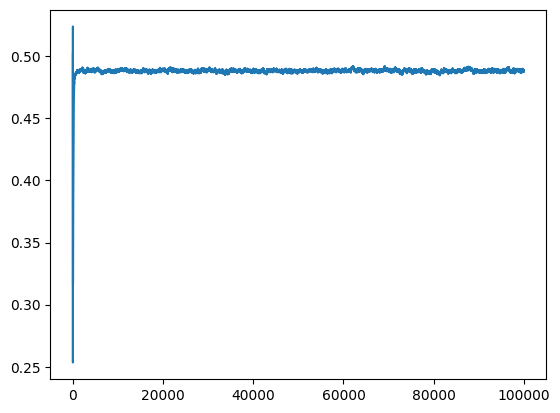

In [17]:
plt.plot(best_ind)

In [ ]:
# Now lets find the average number of fitness calls for each problem instance

TOURNAMENT_SIZE = 10
POP_SIZE = 10 # must be even number
NUM_BITS = 1000
MUT_RATE = 1 / NUM_BITS
MAX_GENS = 1000

problem_sizes = [1, 2, 5, 10]

for problem_size in problem_sizes:
    num_fitness_calls = []

    for i in range(10):
        problem = lab9_lib.make_problem(problem_size)
        inds, fitness_scores, gens = ga(problem, TOURNAMENT_SIZE, MUT_RATE, POP_SIZE, NUM_BITS, MAX_GENS)
        num_fitness_calls.append(problem.calls)
    
    average = np.array(num_fitness_calls).sum() / 100

    print(f"Average number of fitness calls for problem size ({problem_size}): {average}")
    

KeyboardInterrupt: 